In [1]:
from sklearnex import patch_sklearn
patch_sklearn()

import re
import sys
import os

sys.path.append(os.path.abspath(os.path.join("..")))

import numpy as np
from tqdm import tqdm
import pandas as pd
import optuna
from pymystem3 import Mystem
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from joblib import Parallel, delayed

from utils import calc_metrics

import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 41825352
num_columns = ['inflation', 'rate', 'usd', 'usd_cur_change_relative']

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
c:\Users\user\miniconda3\envs\ml_yp\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
X = pd.read_csv('../data/x.csv', index_col='date')
y = pd.read_csv('../data/y.csv', index_col='date').iloc[:, 0]

metrics = pd.read_csv('metrics.csv', index_col=0)

scaler = StandardScaler()
scaler.fit(X[num_columns])
X[num_columns] = scaler.transform(X[num_columns])

### Tf-idf и линейная модель

Протестируем TF-IDF на текстах релизов.

In [3]:
mystem = Mystem()
STOP_WORDS = set(stopwords.words('russian'))

def preprocessor(text):
    text = text.lower()
    regex = re.compile('[^а-я А-ЯЁё]')
    text = regex.sub(' ', text)
    text = ' '.join(mystem.lemmatize(text))
    text = ' '.join([word for word in text.split() if word not in STOP_WORDS])
    return text

vectorizer = TfidfVectorizer(
    preprocessor=preprocessor,
)

vectorizer.fit(X.release)

tf_idf = vectorizer.transform(X.release)
Xpreproc = X.release.apply(preprocessor)

In [4]:
auc = Parallel(n_jobs=-1)(delayed(calc_metrics)(
    tf_idf, y,
    LogisticRegression, 
    name='tf-idf l1 only release', 
    plot=False, 
    solver='liblinear', 
    penalty='l1', 
    C=c.item(),
    random_state=RANDOM_STATE
) for c in np.linspace(0.001, 100, 100))

roc_auc, best_model = max(auc, key=lambda x: x[0])

print(f"Лучшая модель - {best_model}")
print(f"ROC-AUC = {roc_auc}")

Лучшая модель - LogisticRegression(C=20.202818181818184, penalty='l1', random_state=41825352,
                   solver='liblinear')
ROC-AUC = 0.7923976608187133


              precision    recall  f1-score   support

        -1.0       0.69      0.78      0.73        23
         0.0       0.54      0.56      0.55        27
         1.0       0.67      0.53      0.59        19

    accuracy                           0.62        69
   macro avg       0.63      0.62      0.62        69
weighted avg       0.62      0.62      0.62        69



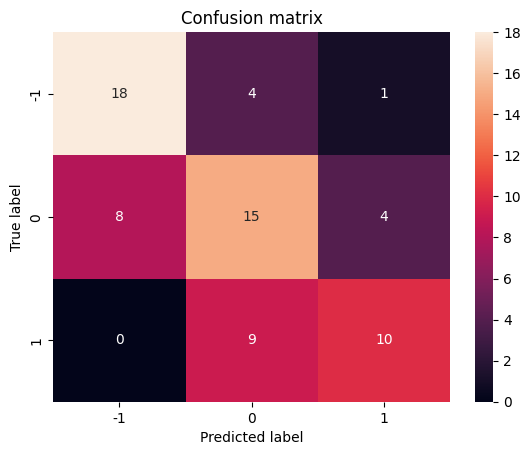

,accuracy,f1,precision,recall,roc_auc_ovr,roc_auc_ovo
min_baseline,0.663265,0.667080,0.667080,0.667080,0.744899,0.750310
bow l1 only release,0.623188,0.628542,0.638829,0.622397,0.770395,0.776563
bow elasticnet,0.608696,0.614159,0.619984,0.610052,0.783943,0.788909
bow release title,0.536232,0.541955,0.563725,0.531486,0.782752,0.788019
bow release all num,0.608696,0.611421,0.622801,0.604854,0.786651,0.791621
bow svc only release,0.652174,0.661011,0.675220,0.652287,0.780628,0.786126
tf_idf l1 only release,0.623188,0.622795,0.631563,0.621493,0.786190,0.792398


In [5]:
metric, model = calc_metrics(
    tf_idf, y, 
    LogisticRegression, 
    name='tf_idf l1 only release', 
    **best_model.get_params()
    )
metrics = pd.concat([metrics, metric], axis=0)
metrics

Как и для мешка слов, используем логистическую регрессию с L1-регуляризацией для отбора признаков и подберем оптимальные параметры:

In [6]:
def objective(trial, texts):
    # параметры для перебора
    params = {
        'C': trial.suggest_float('C', 0.01, 500),
        'C2': trial.suggest_float('C2', 0.01, 500),
        'l1_ratio': trial.suggest_float('l1_ratio', 0.001, 1),
        'max_df': trial.suggest_float('max_df', 0.1, 1),
        'min_df': trial.suggest_int('min_df', 1, 10),
    }

    # векторизуем текст
    vectorizer = TfidfVectorizer(max_df=params['max_df'], min_df=params['min_df'])
    tf_idf = vectorizer.fit_transform(texts).toarray()

    # определяем модель для отбора признаков
    estimator = LogisticRegression(
        penalty="l1", solver="liblinear", C=params["C"], max_iter=1000, random_state=RANDOM_STATE
    )

    # определяем pipeline
    pipeline = Pipeline([
        ("selector", SelectFromModel(estimator)),
        (
            "model",
            LogisticRegression(C=params["C2"], l1_ratio=params["l1_ratio"], solver='saga',
                                     penalty='elasticnet', max_iter=10000,
                                     random_state=RANDOM_STATE),
        ),
    ])

    # считаем метрики на кросс валидации
    try:
        metric, _ = calc_metrics(tf_idf, y, pipeline, name=" ", plot=False, calc_jobs=-1)
    except ValueError or IndexError:
        return -np.inf

    return metric

# устанавливаем уровень логирования optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

# запускаем подбор гиперпараметров
study = optuna.create_study(direction="maximize")
study.optimize(lambda trial: objective(trial, Xpreproc), n_trials=100, show_progress_bar=True)

Best trial: 85. Best value: 0.817499: 100%|██████████| 100/100 [01:18<00:00,  1.28it/s]


In [7]:
study.best_params

{'C': 478.0390111322682,
 'C2': 288.6860870225076,
 'l1_ratio': 0.9482044176545048,
 'max_df': 0.9774489367738072,
 'min_df': 8}

              precision    recall  f1-score   support

        -1.0       0.76      0.83      0.79        23
         0.0       0.62      0.67      0.64        27
         1.0       0.80      0.63      0.71        19

    accuracy                           0.71        69
   macro avg       0.73      0.71      0.71        69
weighted avg       0.72      0.71      0.71        69



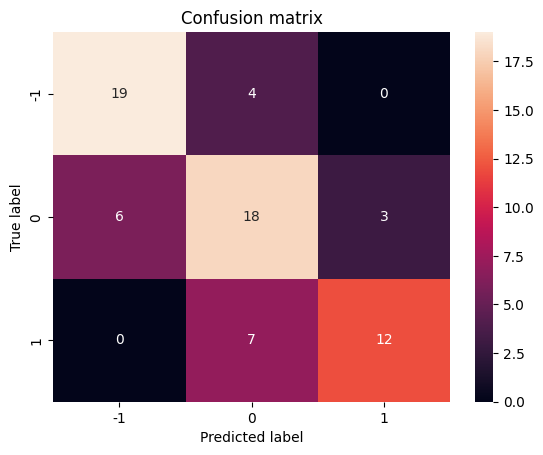

,accuracy,f1,precision,recall,roc_auc_ovr,roc_auc_ovo
min_baseline,0.663265,0.667080,0.667080,0.667080,0.744899,0.750310
bow l1 only release,0.623188,0.628542,0.638829,0.622397,0.770395,0.776563
bow elasticnet,0.608696,0.614159,0.619984,0.610052,0.783943,0.788909
bow release title,0.536232,0.541955,0.563725,0.531486,0.782752,0.788019
bow release all num,0.608696,0.611421,0.622801,0.604854,0.786651,0.791621
bow svc only release,0.652174,0.661011,0.675220,0.652287,0.780628,0.786126
tf_idf l1 only release,0.623188,0.622795,0.631563,0.621493,0.786190,0.792398
tf_idf only release best word,0.710145,0.713469,0.726897,0.708111,0.812164,0.817499


In [8]:
vectorizer = TfidfVectorizer(preprocessor=preprocessor,
                             min_df=study.best_params["min_df"],
                             max_df=study.best_params["max_df"])

tf_idf = vectorizer.fit_transform(X.release).toarray()

estimator = LogisticRegression(
    penalty="l1", solver="liblinear", C=study.best_params["C"], max_iter=1000, random_state=RANDOM_STATE
)

pipeline = Pipeline([
    ("selector", SelectFromModel(estimator)),
    (
        "model",
        LogisticRegression(C=study.best_params["C2"], l1_ratio=study.best_params["l1_ratio"], solver='saga',
                                    penalty='elasticnet', max_iter=10000,
                                    random_state=RANDOM_STATE),
    ),
])

metric, model = calc_metrics(
    tf_idf, y, 
    pipeline, 
    name='tf_idf only release best word'
)

metrics = pd.concat([metrics, metric], axis=0)
metrics

Качество еще немного подросло. Как и в случае с мешком слов попробуем обучить tf-idf на названиях и добавим эти переменые в матрицу объект-признак.

In [9]:
text_titles = X.title.apply(preprocessor) + ' ' + Xpreproc

study = optuna.create_study(direction="maximize")
study.optimize(lambda trial: objective(trial, text_titles), n_trials=100, show_progress_bar=True)

Best trial: 65. Best value: 0.824618: 100%|██████████| 100/100 [00:46<00:00,  2.14it/s]


              precision    recall  f1-score   support

        -1.0       0.78      0.78      0.78        23
         0.0       0.59      0.70      0.64        27
         1.0       0.79      0.58      0.67        19

    accuracy                           0.70        69
   macro avg       0.72      0.69      0.70        69
weighted avg       0.71      0.70      0.70        69



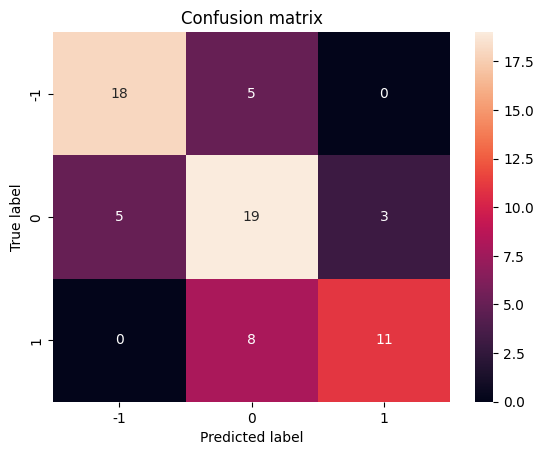

,accuracy,f1,precision,recall,roc_auc_ovr,roc_auc_ovo
min_baseline,0.663265,0.667080,0.667080,0.667080,0.744899,0.750310
bow l1 only release,0.623188,0.628542,0.638829,0.622397,0.770395,0.776563
bow elasticnet,0.608696,0.614159,0.619984,0.610052,0.783943,0.788909
bow release title,0.536232,0.541955,0.563725,0.531486,0.782752,0.788019
bow release all num,0.608696,0.611421,0.622801,0.604854,0.786651,0.791621
bow svc only release,0.652174,0.661011,0.675220,0.652287,0.780628,0.786126
tf_idf l1 only release,0.623188,0.622795,0.631563,0.621493,0.786190,0.792398
tf_idf only release best word,0.710145,0.713469,0.726897,0.708111,0.812164,0.817499
tf_idf title release,0.695652,0.697781,0.720691,0.688420,0.819546,0.824618


In [10]:
vectorizer = TfidfVectorizer(preprocessor=preprocessor,
                             min_df=study.best_params["min_df"],
                             max_df=study.best_params["max_df"])

tf_idf_title = vectorizer.fit_transform(X.title + ' ' + X.release).toarray()

estimator = LogisticRegression(
    penalty="l1", solver="liblinear", C=study.best_params["C"], max_iter=1000, random_state=RANDOM_STATE
)

pipeline = Pipeline([
    ("selector", SelectFromModel(estimator)),
    (
        "model",
        LogisticRegression(C=study.best_params["C2"], l1_ratio=study.best_params["l1_ratio"], solver='saga',
                                    penalty='elasticnet', max_iter=10000,
                                    random_state=RANDOM_STATE),
    ),
])

metric, model = calc_metrics(
    tf_idf_title, y, 
    pipeline, 
    name='tf_idf title release', 
)

metrics = pd.concat([metrics, metric], axis=0)
metrics

При добавлении названия качество модели падает по метрике accuracy. Попробуем добавить количественные переменные.

In [11]:
def objective(trial):
    # параметры для перебора
    params = {
        'C': trial.suggest_float('C', 0.01, 500),
        'C2': trial.suggest_float('C2', 0.01, 500),
        'l1_ratio': trial.suggest_float('l1_ratio', 0.001, 1),
        'max_df': trial.suggest_float('max_df', 0.1, 1),
        'min_df': trial.suggest_int('min_df', 1, 10),
    }

    # векторизуем текст
    vectorizer = TfidfVectorizer(max_df=params['max_df'], min_df=params['min_df'])
    tf_idf = vectorizer.fit_transform(Xpreproc).toarray()

    # добавляем числовые признаки
    tf_idf_num = np.concatenate((tf_idf, X[num_columns].values), axis=1)

    # определяем модель для отбора признаков
    estimator = LogisticRegression(
        penalty="l1", solver="liblinear", C=params["C"], max_iter=1000, random_state=RANDOM_STATE
    )

    # определяем pipeline
    pipeline = Pipeline([
        ("selector", SelectFromModel(estimator)),
        (
            "model",
            LogisticRegression(C=params["C2"], l1_ratio=params["l1_ratio"], solver='saga',
                                     penalty='elasticnet', max_iter=10000,
                                     random_state=RANDOM_STATE),
        ),
    ])

    # считаем метрики на кросс валидации
    try:
        metric, _ = calc_metrics(tf_idf_num, y, pipeline, name=" ", plot=False, calc_jobs=-1)
    except ValueError or IndexError:
        return -np.inf

    return metric

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, show_progress_bar=True)

Best trial: 66. Best value: 0.771139: 100%|██████████| 100/100 [02:02<00:00,  1.22s/it]


              precision    recall  f1-score   support

        -1.0       0.74      0.61      0.67        23
         0.0       0.56      0.74      0.63        27
         1.0       0.86      0.63      0.73        19

    accuracy                           0.67        69
   macro avg       0.72      0.66      0.68        69
weighted avg       0.70      0.67      0.67        69



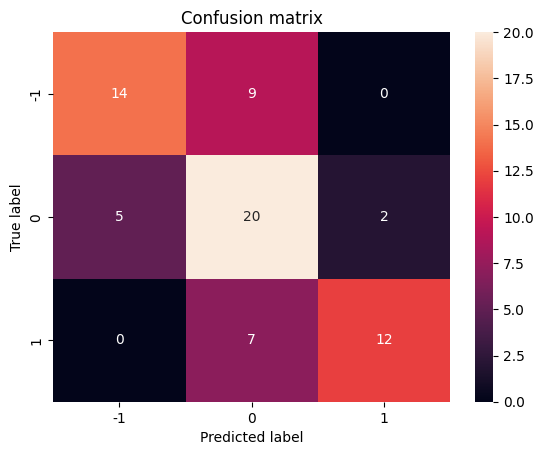

,accuracy,f1,precision,recall,roc_auc_ovr,roc_auc_ovo
min_baseline,0.663265,0.667080,0.667080,0.667080,0.744899,0.750310
bow l1 only release,0.623188,0.628542,0.638829,0.622397,0.770395,0.776563
bow elasticnet,0.608696,0.614159,0.619984,0.610052,0.783943,0.788909
bow release title,0.536232,0.541955,0.563725,0.531486,0.782752,0.788019
bow release all num,0.608696,0.611421,0.622801,0.604854,0.786651,0.791621
bow svc only release,0.652174,0.661011,0.675220,0.652287,0.780628,0.786126
tf_idf l1 only release,0.623188,0.622795,0.631563,0.621493,0.786190,0.792398
tf_idf only release best word,0.710145,0.713469,0.726897,0.708111,0.812164,0.817499
tf_idf title release,0.695652,0.697781,0.720691,0.688420,0.819546,0.824618
tf_idf numerical release,0.666667,0.676287,0.716514,0.660338,0.769350,0.771139


In [12]:
vectorizer = TfidfVectorizer(preprocessor=preprocessor,
                             min_df=study.best_params["min_df"],
                             max_df=study.best_params["max_df"])

tf_idf = vectorizer.fit_transform(X.release).toarray()
tf_idf_num = np.concatenate((tf_idf, X[num_columns].values), axis=1)

estimator = LogisticRegression(
    penalty="l1", solver="liblinear", C=study.best_params["C"], max_iter=1000, random_state=RANDOM_STATE
)

pipeline = Pipeline([
    ("selector", SelectFromModel(estimator)),
    (
        "model",
        LogisticRegression(C=study.best_params["C2"], l1_ratio=study.best_params["l1_ratio"], solver='saga',
                                    penalty='elasticnet', max_iter=10000,
                                    random_state=RANDOM_STATE),
    ),
])

metric, model = calc_metrics(
    tf_idf_num, y,
    pipeline,
    name='tf_idf numerical release', 
)

metrics = pd.concat([metrics, metric], axis=0)
metrics

Добавление числовых данных только ухудшило нашу модель. Попробуем обучить SVC, на tf-idf матрице лучших слов.

In [13]:
def objective(trial, texts):
    # параметры для перебора
    params = {
        'C': trial.suggest_float('C', 0.01, 500),
        'C2': trial.suggest_float('C2', 0.01, 500),
        'kernel': trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid']),
        'max_df': trial.suggest_float('max_df', 0.1, 1),
        'min_df': trial.suggest_int('min_df', 1, 10),
    }

    # векторизуем текст
    vectorizer = TfidfVectorizer(max_df=params['max_df'], min_df=params['min_df'])
    tf_idf = vectorizer.fit_transform(texts).toarray()

    # определяем модель для отбора признаков
    estimator = LogisticRegression(
        penalty="l1", solver="liblinear", C=params["C"], max_iter=1000, random_state=RANDOM_STATE
    )

    # определяем pipeline
    pipeline = Pipeline([
        ("selector", SelectFromModel(estimator)),
        (
            "model",
            SVC(C=params["C2"], kernel=params['kernel'], probability=True, random_state=RANDOM_STATE),
        ),
    ])

    # считаем метрики на кросс валидации
    try:
        metric, _ = calc_metrics(tf_idf, y, pipeline, name=" ", plot=False, calc_jobs=-1)
    except ValueError or IndexError:
        return -np.inf

    return metric

# запускаем подбор гиперпараметров
study = optuna.create_study(direction="maximize")
study.optimize(lambda trial: objective(trial, Xpreproc), n_trials=100, show_progress_bar=True)

Best trial: 27. Best value: 0.85551: 100%|██████████| 100/100 [00:22<00:00,  4.48it/s]


In [14]:
study.best_params

{'C': 231.23750153356926,
 'C2': 33.88237627399739,
 'kernel': 'rbf',
 'max_df': 0.9707554021493154,
 'min_df': 8}

              precision    recall  f1-score   support

        -1.0       0.77      0.87      0.82        23
         0.0       0.63      0.70      0.67        27
         1.0       0.85      0.58      0.69        19

    accuracy                           0.72        69
   macro avg       0.75      0.72      0.72        69
weighted avg       0.74      0.72      0.72        69



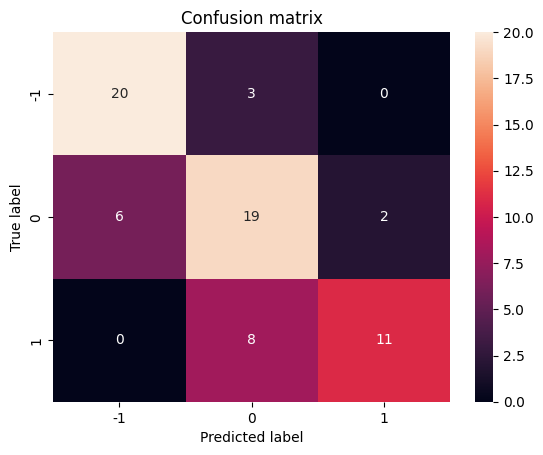

,accuracy,f1,precision,recall,roc_auc_ovr,roc_auc_ovo
min_baseline,0.663265,0.667080,0.667080,0.667080,0.744899,0.750310
bow l1 only release,0.623188,0.628542,0.638829,0.622397,0.770395,0.776563
bow elasticnet,0.608696,0.614159,0.619984,0.610052,0.783943,0.788909
bow release title,0.536232,0.541955,0.563725,0.531486,0.782752,0.788019
bow release all num,0.608696,0.611421,0.622801,0.604854,0.786651,0.791621
bow svc only release,0.652174,0.661011,0.675220,0.652287,0.780628,0.786126
tf_idf l1 only release,0.623188,0.622795,0.631563,0.621493,0.786190,0.792398
tf_idf only release best word,0.710145,0.713469,0.726897,0.708111,0.812164,0.817499
tf_idf title release,0.695652,0.697781,0.720691,0.688420,0.819546,0.824618
tf_idf numerical release,0.666667,0.676287,0.716514,0.660338,0.769350,0.771139


In [15]:
vectorizer = TfidfVectorizer(preprocessor=preprocessor,
                             min_df=study.best_params["min_df"],
                             max_df=study.best_params["max_df"])

tf_idf = vectorizer.fit_transform(X.release).toarray()

estimator = LogisticRegression(
    penalty="l1", solver="liblinear", C=study.best_params["C"], max_iter=1000, random_state=RANDOM_STATE
)

pipeline = Pipeline([
    ("selector", SelectFromModel(estimator)),
    (
        "model",
        SVC(C=study.best_params["C2"], kernel=study.best_params['kernel'],
            probability=True, random_state=RANDOM_STATE),
    ),
])

metric, _ = calc_metrics(
    tf_idf, y, 
    pipeline, 
    name='tf-idf svc only release', 
)

metrics = pd.concat([metrics, metric])
metrics

Мы еще немного улучшились.

In [16]:
metrics.to_csv('metrics.csv')